In [252]:
import os
import math
import time
import random
import torch
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
#import autosklearn.classification
from sklearn.model_selection import train_test_split

In [253]:
def train_test_eq_split(X, y, n_per_class, random_state=None):
    if random_state:
        np.random.seed(random_state)
    sampled = X.groupby(y[0], sort=False).apply(lambda frame: frame.sample(n_per_class))
    mask = sampled.index.get_level_values(1)
    X_train = X.drop(mask)
    X_test = X.loc[mask]
    y_train = y.drop(mask)
    y_test = y.loc[mask]
    return X_train, X_test, y_train, y_test

## Read Data

In [254]:
most_images_data = scipy.io.loadmat('6845348/natimg2800_M170714_MP032_2017-09-14.mat')
#most_neurons_data = scipy.io.loadmat('6845348/natimg2800_M161025_MP030_2017-05-29.mat')
images_categories = scipy.io.loadmat('6845348/stimuli_class_assignment.mat')

In [255]:
### stimulus responses
resp = most_images_data['stim'][0]['resp'][0] # stimuli by neurons
istim = most_images_data['stim'][0]['istim'][0] # identities of stimuli in resp
cats = images_categories['class_assignment'][0] # cateogries of stimuli

'''
mt = sio.loadmat('images_natimg2800_all.mat')
imgs = mt['imgs']  # 68 by 270 by number of images
plt.imshow(imgs[:,:,0])
'''

"\nmt = sio.loadmat('images_natimg2800_all.mat')\nimgs = mt['imgs']  # 68 by 270 by number of images\nplt.imshow(imgs[:,:,0])\n"

## Preprocessing

#### 15 classes from 1 to 15 ('birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 'pellets', 'snakes', 'wildcats', 'other animals', 'other natural', 'other man made') and an additional 'unknown' class = 0.
#### Class 16 = Gray Image
#### Total = 17 classes

##### Extract Images Labels / Categories

In [256]:
labels_str = ['unknown', 'birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 
             'pellets', 'snakes', 'wildcats', 'animals', 'natural', 'man_made', 'grey']

In [257]:
labels = np.zeros(len(istim))
for i in range(len(istim)):
    if istim[i] - 1 == 2800:
        labels[i] = 16 #gray image
    else:
        labels[i] = cats[istim[i] - 1]

In [258]:
import collections
counter=collections.Counter(labels)
counter

Counter({1.0: 832,
         2.0: 651,
         10.0: 120,
         16.0: 335,
         9.0: 199,
         6.0: 660,
         4.0: 613,
         7.0: 903,
         5.0: 99,
         12.0: 190,
         13.0: 229,
         8.0: 889,
         11.0: 376,
         15.0: 84,
         14.0: 253,
         0.0: 239,
         3.0: 308})

([<matplotlib.axis.XTick at 0x1db05c3a588>,
 <a list of 17 Text xticklabel objects>)

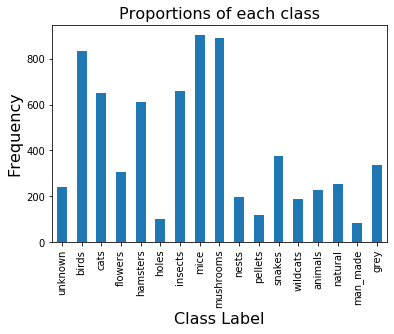

In [259]:
stars = pd.Series(labels)
vc = stars.value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
plt.title('Proportions of each class', fontsize = 16)
plt.xlabel('Class Label', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(np.arange(17), labels_str)

##### Convert to Pandas

In [260]:
X_data = pd.DataFrame(data = resp)
y_data = pd.DataFrame(data = labels)

##### Split Dataset

In [261]:
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=22)
X_train, X_test, y_train, y_test = train_test_eq_split(X_data, y_data, n_per_class=75, random_state=22)

In [262]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### SMOTE


In [246]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [67]:
clf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=22)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
y_pred_tr = clf.predict(X_train)
print('Train - Accuracy: ', accuracy_score(y_train, y_pred_tr))

Accuracy:  0.16470588235294117
Train - Accuracy:  0.7428246660983234


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier(max_depth = 5, random_state=22)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('XGB Accuracy:', accuracy_score(y_test, y_pred))
y_pred_tr = model.predict(X_train)
print('Train - Accuracy: ', accuracy_score(y_train, y_pred_tr))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), random_state=22)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
y_pred_tr = clf2.predict(X_train)
print('Train - Accuracy: ', accuracy_score(y_train, y_pred_tr))

### Feature Selection From Decision Tree

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline([
  ('feature_selection', SelectFromModel(DecisionTreeClassifier(max_depth = 10, max_features = 1000))),
  ('classification', RandomForestClassifier(n_estimators=500, max_depth=10, random_state=22))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.1380392156862745


### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
#selector = RFE(estimator, 5, step=1)
clf = Pipeline([
  ('feature_selection', RFE(DecisionTreeClassifier(max_depth = 10), 1000)),
  ('classification', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=22))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

### Univariate Feature Elimination

In [69]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
clf = Pipeline([
  ('feature_selection', SelectKBest(f_classif, k=1000)),
  ('classification', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=22))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [5242] are constant.
  UserWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Accuracy:  0.15215686274509804


# Different Feature Reduction Methods

In [70]:
'''
This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 
Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
This means it can work with scipy.sparse matrices efficiently.
'''
from sklearn.decomposition import TruncatedSVD
'''
Principal component analysis (PCA)
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
The input data is centered but not scaled for each feature before applying the SVD.
'''
from sklearn.decomposition import PCA
'''
Incremental principal components analysis (IPCA).
Linear dimensionality reduction using Singular Value Decomposition of the data, keeping only the most significant singular 
vectors to project the data to a lower dimensional space. 
The input data is centered but not scaled for each feature before applying the SVD.
'''
from sklearn.decomposition import IncrementalPCA
'''
Factor Analysis (FA)
A simple linear generative model with Gaussian latent variables.
The observations are assumed to be caused by a linear transformation of lower dimensional latent factors and added 
Gaussian noise. 
Without loss of generality the factors are distributed according to a Gaussian with zero mean and unit covariance. 
The noise is also zero mean and has an arbitrary diagonal covariance matrix.
'''
from sklearn.decomposition import FactorAnalysis
'''
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities 
and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and 
the high-dimensional data. t-SNE has a cost function that is not convex, 
i.e. with different initializations we can get different results.
'''
from sklearn.manifold import TSNE

##### Truncated SVD [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

In [98]:
#Truncated SVD
truncsvd_model = TruncatedSVD(n_components=100, random_state = 22).fit(X_train)
truncsvd_data = truncsvd_model.transform(X_test)
truncsvd_train_data = truncsvd_model.transform(X_train)
print('Finished TruncatedSVD')

Finished TruncatedSVD


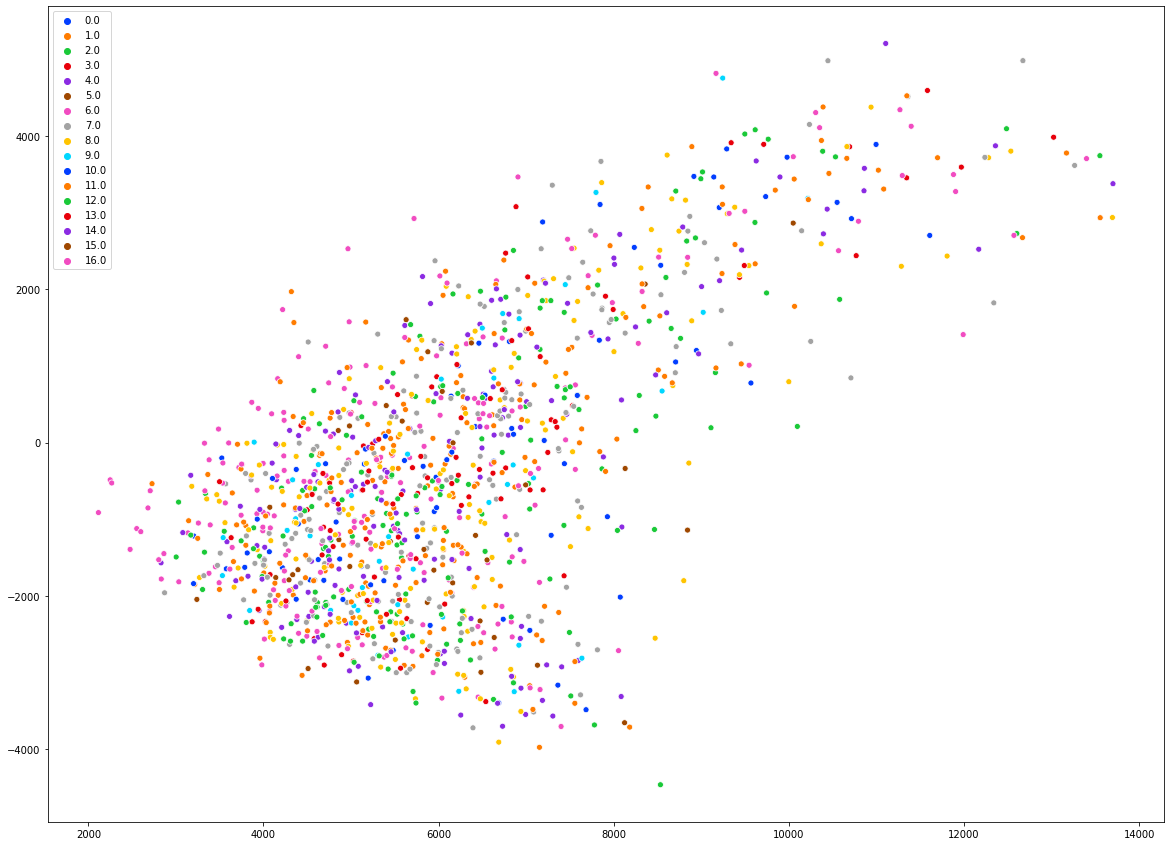

In [16]:
#for 20 components
palette = sns.color_palette("bright", 17)
plt.figure(figsize=(20,15))
sns.scatterplot(truncsvd_data[:,0], truncsvd_data[:,1], legend = 'full', palette = palette, hue = y_test)

In [99]:
clf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=22)
clf.fit(truncsvd_train_data, y_train)
y_pred = clf.predict(truncsvd_data)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.12941176470588237


##### PCA [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [96]:
#PCA
pca_model = PCA(n_components=100, random_state = 22).fit(X_train)
pca_data = pca_model.transform(X_test)
pca_train_data = pca_model.transform(X_train)
print('Finished PCA')

Finished PCA


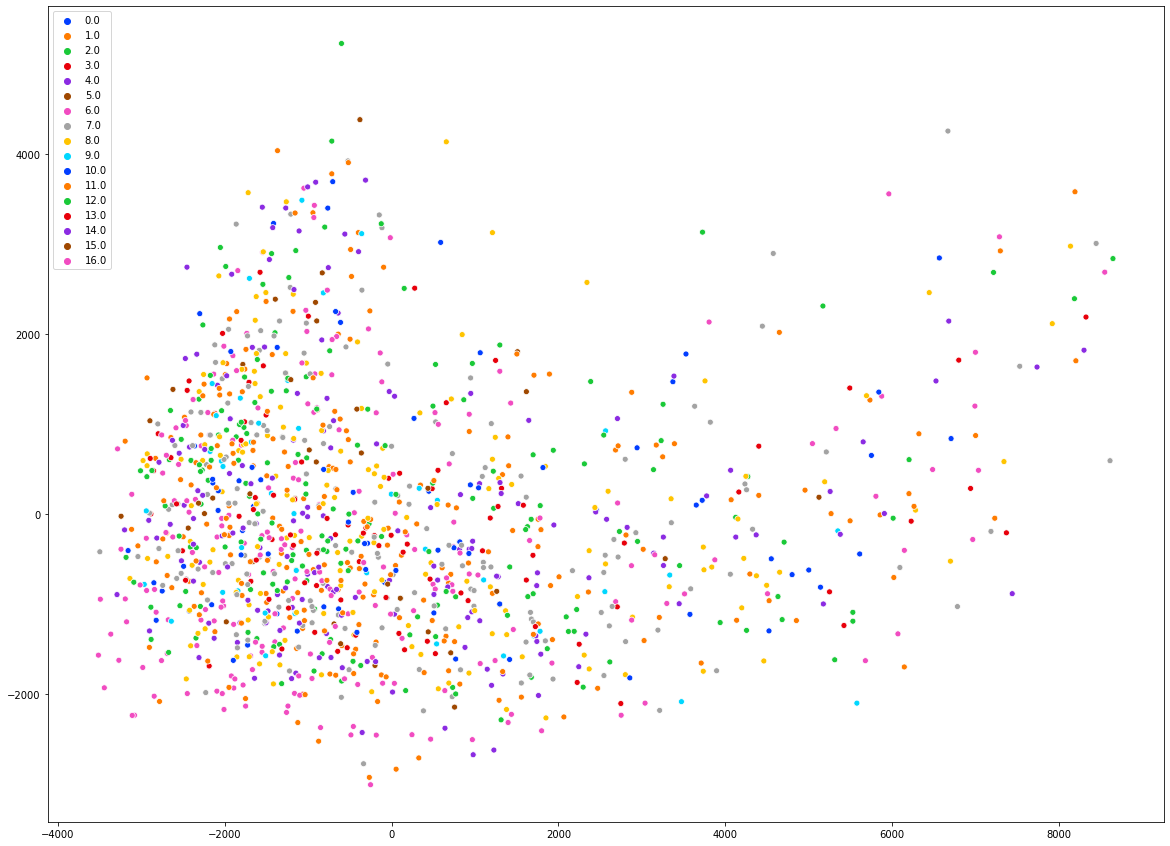

In [19]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(pca_data[:,0], pca_data[:,1], legend = 'full', palette = palette, hue = y_test)

In [97]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=22)
clf.fit(pca_train_data, y_train)
y_pred = clf.predict(pca_data)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.15450980392156863


##### Incremental PCA [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA)

In [91]:
#IPCA
ipca_model = IncrementalPCA(n_components=100, batch_size = 200).fit(X_train)
ipca_data = ipca_model.transform(X_test)
ipca_train_data = ipca_model.transform(X_train)
print('Finished IPCA')

Finished IPCA


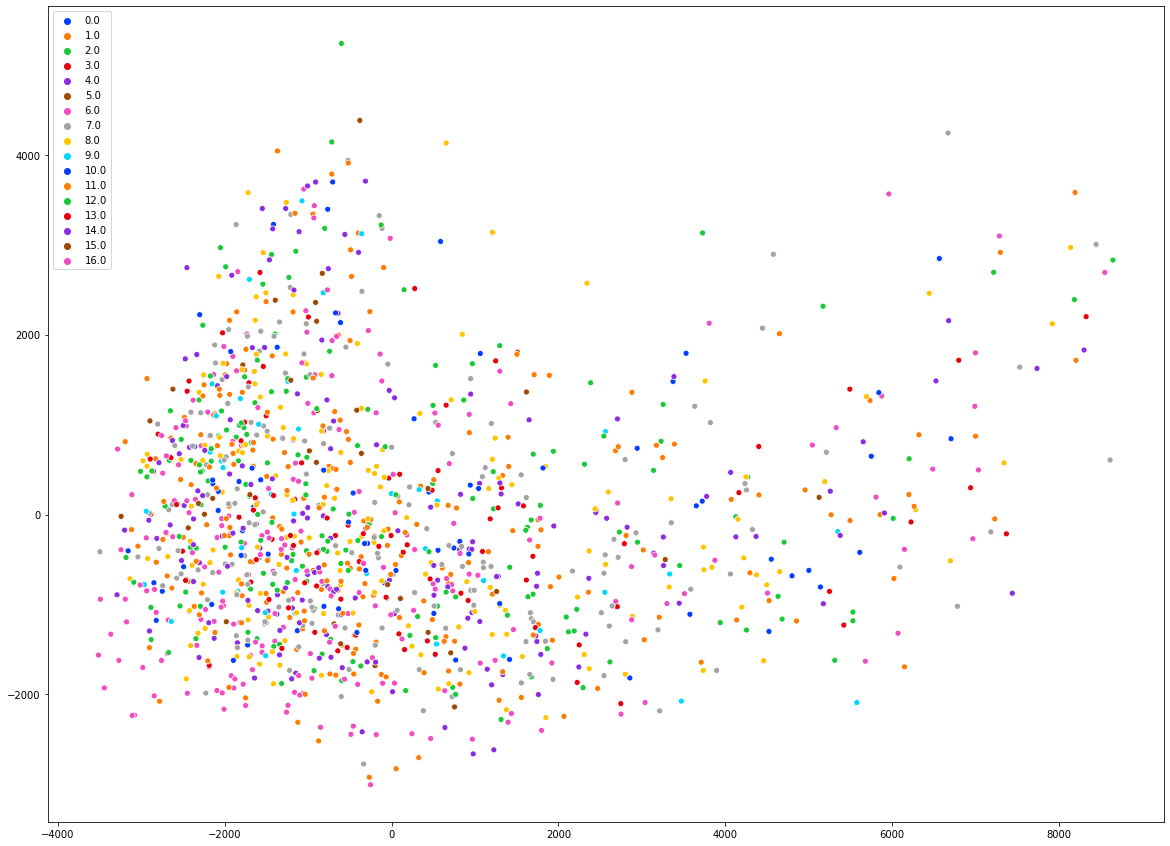

In [22]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(ipca_data[:,0], ipca_data[:,1], legend = 'full', palette = palette, hue = y_test)

In [100]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=22)
clf.fit(ipca_train_data, y_train)
y_pred = clf.predict(ipca_data)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.1623529411764706


##### Factor Analysis [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis)

In [89]:
#Factor Analysis
fa_model = FactorAnalysis(n_components=100, random_state = 22).fit(X_train)
fa_data = fa_model.transform(X_test)
fa_train_data = fa_model.transform(X_train)
print('Finished Factor Analysis')

Finished Factor Analysis


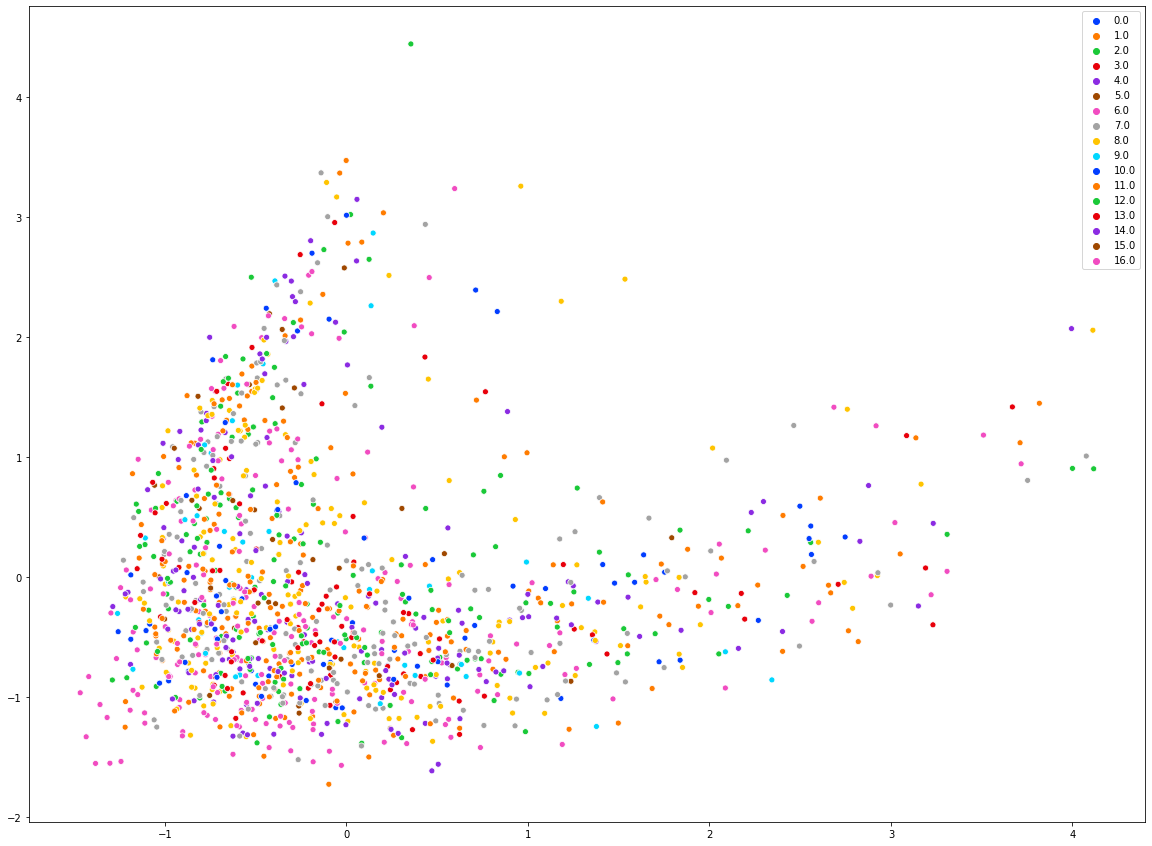

In [25]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(fa_data[:,0], fa_data[:,1], legend = 'full', palette = palette, hue = y_test)

In [90]:
clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=22)
clf.fit(fa_train_data, y_train)
y_pred = clf.predict(fa_data)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.13725490196078433


##### t-SNE [doc](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**Note:** can't be used...just for vizualization.

In [27]:
X_tsne = TSNE(n_components=2).fit_transform(X_train)


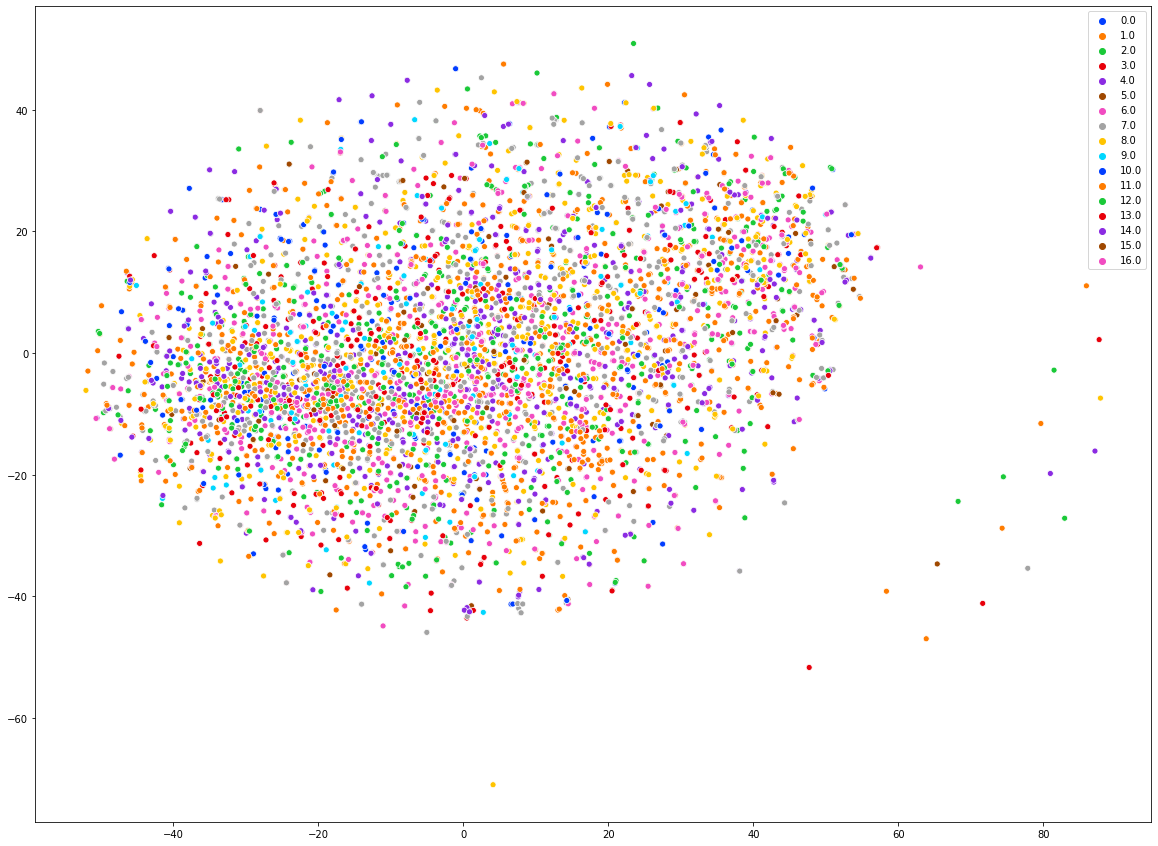

In [29]:
plt.figure(figsize=(20,15))
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], legend = 'full', palette = palette, hue = y_train)

### Pytorch - MLP

#### Standardization

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [51]:
import torchvision
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision.transforms as transforms

In [52]:
# Hyper-parameters 
input_size = X_train.shape[1]
hidden_size1 = 16384
hidden_size2 = 4096
hidden_size3 = 1024
hidden_size4 = 128
num_classes = 17
num_epochs = 5
batch_size = 128
learning_rate = 1e-4

In [53]:
train_target = torch.tensor(y_train.astype(np.long), dtype=torch.long)
train = torch.tensor(X_train_std.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [54]:
test_target = torch.tensor(y_test.astype(np.long), dtype=torch.long)
test = torch.tensor(X_test_std.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [55]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.5)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bn1(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bn2(out)
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bn3(out)
        out = self.fc4(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bn4(out)
        out = self.fc5(out)
        return out

In [56]:
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [57]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (data, labelsNN) in enumerate(train_loader):  
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labelsNN)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [20/110], Loss: 2.5699
Epoch [1/5], Step [40/110], Loss: 2.4209
Epoch [1/5], Step [60/110], Loss: 2.2621
Epoch [1/5], Step [80/110], Loss: 2.0070
Epoch [1/5], Step [100/110], Loss: 1.8783
Epoch [2/5], Step [20/110], Loss: 1.7175
Epoch [2/5], Step [40/110], Loss: 1.5203
Epoch [2/5], Step [60/110], Loss: 1.3152
Epoch [2/5], Step [80/110], Loss: 1.2731
Epoch [2/5], Step [100/110], Loss: 1.2018
Epoch [3/5], Step [20/110], Loss: 1.1005
Epoch [3/5], Step [40/110], Loss: 0.9599
Epoch [3/5], Step [60/110], Loss: 0.9511
Epoch [3/5], Step [80/110], Loss: 1.0067
Epoch [3/5], Step [100/110], Loss: 0.9083
Epoch [4/5], Step [20/110], Loss: 0.7664
Epoch [4/5], Step [40/110], Loss: 0.7086
Epoch [4/5], Step [60/110], Loss: 0.6050
Epoch [4/5], Step [80/110], Loss: 0.6445
Epoch [4/5], Step [100/110], Loss: 0.5579
Epoch [5/5], Step [20/110], Loss: 0.4880
Epoch [5/5], Step [40/110], Loss: 0.5133
Epoch [5/5], Step [60/110], Loss: 0.4181
Epoch [5/5], Step [80/110], Loss: 0.3425
Epoch [5/5],

In [58]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in test_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))

Avg. Test Loss: tensor(2.7744)
Accuracy of the network: 22.11764705882353 %



# Class Merging

In [263]:
# grey = 0
# unknown, man made, pellets, holes, nests --> unknown = 1
# cats, wildcats, animals, snakes, birds --> animals = 2
# natural, flowers, mushrooms --> natural = 3
# insects = 4
# mice, hamsters --> mice = 5
labels_new_str = ['grey', 'unknown', 'animals', 'natural', 'insects', 'mice']
conv = {'grey':0, 'unknown':1, 'birds':2, 'cats':2, 'flowers':3, 'hamsters':2, 'holes':1, 'insects':4, 'mice':5, 
        'mushrooms':3, 'nests':1, 'pellets':1, 'snakes':2, 'wildcats':2, 'animals':2, 'natural':3, 'man_made':1}

In [264]:
labels_new = []
y_train_new = y_train.copy()
y_test_new = y_test.copy()
for i in range(len(y_train_new)):
    y_train_new[i] = conv[ labels_str[ int(y_train_new[i]) ] ]
    labels_new.append(y_train_new[i])
for i in range(len(y_test_new)):
    y_test_new[i] = conv[labels_str[ int(y_test_new[i]) ] ]
    labels_new.append(y_train_new[i])

In [265]:
import collections
counter=collections.Counter(labels_new)
counter

Counter({2.0: 2967, 1.0: 454, 4.0: 713, 5.0: 1008, 3.0: 1513, 0.0: 325})

([<matplotlib.axis.XTick at 0x1db058bc9b0>,
 <a list of 6 Text xticklabel objects>)

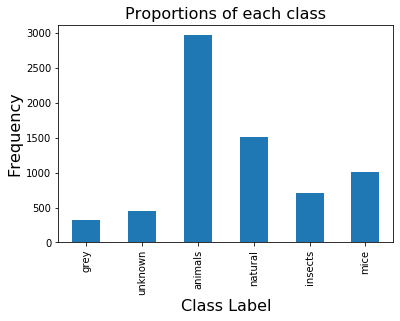

In [266]:
stars = pd.Series(labels_new)
vc = stars.value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
plt.title('Proportions of each class', fontsize = 16)
plt.xlabel('Class Label', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(np.arange(6), labels_new_str)

In [267]:
X_train2, y_train_new = sm.fit_resample(X_train, y_train_new)

In [268]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=22)
clf.fit(X_train2, y_train_new)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))
y_pred = clf.predict(X_train2)
print('Accuracy: ', accuracy_score(y_train_new, y_pred))

Accuracy:  0.39137254901960783
Accuracy:  0.7141881742455278


##### Truncated SVD [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

In [ ]:
#for 20 components
palette2 = sns.color_palette("bright", 6)
plt.figure(figsize=(20,15))
sns.scatterplot(truncsvd_data[:,0], truncsvd_data[:,1], legend = 'full', palette = palette2, hue = y_test_new)

In [46]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=22)
clf.fit(truncsvd_train_data, y_train_new)
y_pred = clf.predict(truncsvd_data)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  0.37034383954154726


##### PCA [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [ ]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(pca_data[:,0], pca_data[:,1], legend = 'full', palette = palette2, hue = y_test_new)

In [48]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=22)
clf.fit(pca_train_data, y_train_new)
y_pred = clf.predict(pca_data)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  0.3510028653295129


##### Incremental PCA [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA)

In [ ]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(ipca_data[:,0], ipca_data[:,1], legend = 'full', palette = palette2, hue = y_test_new)

In [50]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=22)
clf.fit(ipca_train_data, y_train_new)
y_pred = clf.predict(ipca_data)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  0.3538681948424069


##### Factor Analysis [doc](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis)

In [ ]:
#for 20 components
plt.figure(figsize=(20,15))
sns.scatterplot(fa_data[:,0], fa_data[:,1], legend = 'full', palette = palette2, hue = y_test_new)

In [52]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=22)
clf.fit(fa_train_data, y_train_new)
y_pred = clf.predict(fa_data)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  0.3230659025787966


##### t-SNE [doc](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**Note:** can't be used...just for vizualization.

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], legend = 'full', palette = palette2, hue = y_train_new)

### Pytorch - MLP

In [269]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train2)
X_train_std = scaler.transform(X_train2)

In [270]:
train_target = torch.tensor(y_train_new.astype(np.long), dtype=torch.long)
train = torch.tensor(X_train_std.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [271]:
test_target = torch.tensor(y_test_new.astype(np.long), dtype=torch.long)
test = torch.tensor(X_test_std.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [281]:
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

In [282]:
# Train the model
total_step = len(train_loader)
for epoch in range(3):
    for i, (data, labelsNN) in enumerate(train_loader):  
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labelsNN)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [20/115], Loss: 2.4035
Epoch [1/5], Step [40/115], Loss: 2.0651
Epoch [1/5], Step [60/115], Loss: 1.9970
Epoch [1/5], Step [80/115], Loss: 1.5793
Epoch [1/5], Step [100/115], Loss: 1.3150
Epoch [2/5], Step [20/115], Loss: 1.0484
Epoch [2/5], Step [40/115], Loss: 0.7810
Epoch [2/5], Step [60/115], Loss: 0.7556
Epoch [2/5], Step [80/115], Loss: 0.7121
Epoch [2/5], Step [100/115], Loss: 0.6642
Epoch [3/5], Step [20/115], Loss: 0.4528
Epoch [3/5], Step [40/115], Loss: 0.4069
Epoch [3/5], Step [60/115], Loss: 0.3566
Epoch [3/5], Step [80/115], Loss: 0.3555
Epoch [3/5], Step [100/115], Loss: 0.3512


In [283]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in test_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in train_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))

Avg. Test Loss: tensor(2.7720)
Accuracy of the network: 32.3921568627451 %
Avg. Test Loss: tensor(0.2468)
Accuracy of the network: 99.46060357776868 %


In [277]:
np.unique(y_test_new)

array([0., 1., 2., 3., 4., 5.])

<hr>

### AutoSklearn - Different Classifiers

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 22000, ensemble_size = 1,
                                                         ensemble_memory_limit = 5500, ml_memory_limit = 5500)
automl.fit(X_train_std, y_train_new)

In [22]:
y_pred = automl.predict(X_test_std)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  0.3939828080229226


In [24]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: 95e1300aa14699708c1c9177e1b1d848\n  Metric: accuracy\n  Best validation score: 0.406403\n  Number of target algorithm runs: 150\n  Number of successful target algorithm runs: 109\n  Number of crashed target algorithm runs: 8\n  Number of target algorithms that exceeded the time limit: 25\n  Number of target algorithms that exceeded the memory limit: 8\n'

In [25]:
automl.get_params()

{'delete_output_folder_after_terminate': True,
 'delete_tmp_folder_after_terminate': True,
 'disable_evaluator_output': False,
 'ensemble_memory_limit': 5500,
 'ensemble_nbest': 50,
 'ensemble_size': 1,
 'exclude_estimators': None,
 'exclude_preprocessors': None,
 'get_smac_object_callback': None,
 'include_estimators': None,
 'include_preprocessors': None,
 'initial_configurations_via_metalearning': 25,
 'logging_config': None,
 'metadata_directory': None,
 'ml_memory_limit': 5500,
 'n_jobs': None,
 'output_folder': None,
 'per_run_time_limit': 360,
 'resampling_strategy': 'holdout',
 'resampling_strategy_arguments': None,
 'seed': 1,
 'shared_mode': False,
 'smac_scenario_args': None,
 'time_left_for_this_task': 22000,
 'tmp_folder': None}

In [26]:
automl.show_models()

"[(1.000000, SimpleClassificationPipeline({'classifier:passive_aggressive:tol': 1.5099542326343014e-05, 'classifier:passive_aggressive:fit_intercept': 'True', 'preprocessor:nystroem_sampler:kernel': 'cosine', 'classifier:passive_aggressive:average': 'False', 'preprocessor:__choice__': 'nystroem_sampler', 'rescaling:__choice__': 'none', 'preprocessor:nystroem_sampler:n_components': 8532, 'classifier:passive_aggressive:loss': 'hinge', 'classifier:passive_aggressive:C': 1.2538107344750156, 'categorical_encoding:__choice__': 'one_hot_encoding', 'imputation:strategy': 'median', 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'False', 'classifier:__choice__': 'passive_aggressive', 'balancing:strategy': 'weighting'},\ndataset_properties={\n  'task': 2,\n  'multilabel': False,\n  'sparse': False,\n  'multiclass': True,\n  'target_type': 'classification',\n  'signed': False})),\n]"

# Average Responses for each image and normalize by Grey

In [167]:
X_data_avg = X_data.copy(deep = True)
X_data_avg['img_id'] = istim

In [168]:
X_avg = X_data_avg.groupby('img_id').mean().reset_index()
X_avg.tail()

,img_id,0,1,2,3,4,5,6,7,8,...,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
2796,2797,18.286285,5.475191,7.312119,17.661516,5.438449,8.502415,20.277079,1.458136,15.498446,...,6.899031,5.907485,16.486023,1.985680,0.000000,23.495197,6.977427,28.563713,53.257835,58.831486
2797,2798,13.418331,1.681373,9.097526,16.774158,5.912894,0.584047,34.769604,1.883367,0.352513,...,9.044582,1.541514,9.780148,6.382439,6.771379,0.000000,6.573892,190.322113,71.299530,7.149213
2798,2799,18.519575,5.151362,11.243047,6.723980,7.370479,1.251042,24.350960,0.000000,19.303417,...,7.847610,19.624817,10.488205,15.440705,19.819654,69.864975,2.791323,69.241829,12.354649,104.445007
2799,2800,5.024157,45.649441,166.623947,12.519175,1.972102,3.915522,22.461498,1.647021,1.769967,...,8.777534,5.105183,9.639045,45.332283,19.181452,39.594067,9.101516,60.633774,126.102570,250.542252
2800,2801,8.056371,4.486979,12.656736,9.146111,3.349355,3.508668,31.663065,2.843302,6.011918,...,8.804033,8.136412,9.814878,20.602400,10.984198,14.611591,15.877363,30.761339,40.228096,99.068268


In [169]:
grey_index = -1
labels2 = np.zeros(len(X_avg))
for i, row in X_avg.iterrows():
    if row['img_id'] - 1 == 2800:
        labels2[i] = 16 #gray image
        grey_index = i
    else:
        labels2[i] = cats[int(row['img_id'] - 1)]

In [170]:
X_avg_new = X_avg.div(X_avg.iloc[grey_index] + 1, axis='columns')

In [171]:
X_avg_new.drop(['img_id'], axis = 1, inplace = True)

##### Split Dataset

In [172]:
X_data2 = pd.DataFrame(data = X_avg_new[:-1])
y_data2 = pd.DataFrame(data = labels2[:-1])

In [173]:
#X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2, test_size=0.2, random_state=22)
X_train, X_test, y_train, y_test = train_test_eq_split(X_data2, y_data2, n_per_class=30, random_state=22)

In [174]:
len(X_test) / len(X_train)

0.20689655172413793

In [175]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
0,2.046774,1.360277,0.655910,30.207932,0.753110,1.053853,0.663577,1.124340,3.135562,1.400699,...,1.433896,0.736965,1.093834,0.407427,0.718134,14.818714,0.441152,2.011413,3.036999,3.958793
1,0.805042,1.683477,0.043064,0.215116,1.311836,1.751909,0.000000,0.187262,1.451017,0.000000,...,0.921910,0.086884,0.000000,0.000000,0.576322,0.000000,0.027617,0.868327,0.237891,1.958389
2,0.594289,3.814434,4.802963,1.573869,0.842939,2.900581,0.284135,0.085122,0.661464,3.102900,...,1.630454,3.228198,0.905456,1.210008,0.542463,3.447186,0.141710,3.008218,1.274994,7.484028
3,2.636662,0.978900,2.213015,0.668798,0.857409,2.739309,0.416351,1.448998,16.403072,0.547141,...,0.545208,0.458914,0.000000,2.100620,0.435187,0.681706,0.645622,7.778948,2.584816,0.323704
4,0.955614,0.000000,1.551329,1.487294,0.579892,0.988965,0.578250,0.483694,0.000000,1.151037,...,1.467941,0.797865,0.001244,0.525733,0.443093,3.319553,0.135864,1.879852,0.661657,5.126263


In [176]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [177]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [178]:
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=22)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.11666666666666667


### Pytorch - MLP

In [179]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [180]:
train_target = torch.tensor(y_train.astype(np.long), dtype=torch.long)
train = torch.tensor(X_train_std.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [181]:
test_target = torch.tensor(y_test.astype(np.long), dtype=torch.long)
test = torch.tensor(X_test_std.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [182]:
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [183]:
# Train the model
total_step = len(train_loader)
for epoch in range(4):
    for i, (data, labelsNN) in enumerate(train_loader):  
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labelsNN)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [20/44], Loss: 2.3341
Epoch [1/5], Step [40/44], Loss: 1.9026
Epoch [2/5], Step [20/44], Loss: 1.7253
Epoch [2/5], Step [40/44], Loss: 1.5985
Epoch [3/5], Step [20/44], Loss: 1.2453
Epoch [3/5], Step [40/44], Loss: 1.2583
Epoch [4/5], Step [20/44], Loss: 1.2112
Epoch [4/5], Step [40/44], Loss: 1.0892


In [184]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in test_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))

Avg. Test Loss: tensor(2.8832)
Accuracy of the network: 13.958333333333334 %


# Without Averaging normalize by Grey

In [201]:
X_avg_norm = X_avg.drop(['img_id'], axis = 1)

In [202]:
X_data_norm = X_data.copy(deep = True)
X_avg_norm.loc[2800] = X_avg_norm.loc[2800] + 1
X_norm = X_data_norm.div(X_avg_norm.iloc[2800], axis='columns')
X_data3 = pd.DataFrame(data = X_norm)

In [203]:
y_data = pd.DataFrame(data = labels)

In [204]:
X_train, X_test, y_train, y_test = train_test_eq_split(X_data3, y_data, n_per_class=75, random_state=22)

In [205]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [206]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [207]:
clf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=22)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
y_pred_tr = clf.predict(X_train)
print('Accuracy: ', accuracy_score(y_train, y_pred_tr))

Accuracy:  0.14431372549019608
Accuracy:  0.7647058823529411


In [208]:
np.unique(y_train)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

### Try Neural Network

In [210]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [211]:
train_target = torch.tensor(y_train.astype(np.long), dtype=torch.long)
train = torch.tensor(X_train_std.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [212]:
test_target = torch.tensor(y_test.astype(np.long), dtype=torch.long)
test = torch.tensor(X_test_std.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [217]:
num_classes

17

In [218]:
model = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [228]:
# Train the model
total_step = len(train_loader)
for epoch in range(5):
    for i, (data, labelsNN) in enumerate(train_loader):  
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labelsNN)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [20/110], Loss: 0.1764
Epoch [1/5], Step [40/110], Loss: 0.1914
Epoch [1/5], Step [60/110], Loss: 0.1825
Epoch [1/5], Step [80/110], Loss: 0.1733
Epoch [1/5], Step [100/110], Loss: 0.1603


In [229]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in test_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))
    correct = 0
    total = 0
    test_loss = 0
    counter = 0
    for data, labelsNN in train_loader:
        counter += 1
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labelsNN.size(0)
        correct += (predicted == labelsNN).sum().item()
        test_loss += criterion(outputs, labelsNN)
        
    print('Avg. Test Loss:', test_loss / counter)
    print('Accuracy of the network: {} %'.format(100 * correct / total))

Avg. Test Loss: tensor(2.8836)
Accuracy of the network: 23.607843137254903 %
Avg. Test Loss: tensor(0.1535)
Accuracy of the network: 99.95737425404944 %


In [221]:
np.unique(y_test)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])